# GPT mini mini: Treinando meu primeiro transformer do Zero (Parte 1 e 2)

- Motivação 
- Setup de desenvolvimento
- Creação de Dataloader para Pytorch
- Definição do problema de modelos de linguagem 
- Definição do modelo
- Codificação posicional 
- Generação de texto
- Mecanismo de atenção
- Modelo GPT


In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/pedrodiamel/gpt_mini_mini/blob/main/books/gpt_mini_mini_dev.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [2]:
!nvidia-smi

Tue Sep  5 01:14:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.108.03   Driver Version: 510.108.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4500    On   | 00000000:01:00.0  On |                  Off |
| 30%   37C    P5    57W / 200W |    613MiB / 20470MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A4500    On   | 00000000:02:00.0 Off |                  Off |
| 30%   

In [ ]:
using_colab = False

In [ ]:
if using_colab:
    import torch
    print("PyTorch version:", torch.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    #!pip install git+https://github.com/pedrodiamel/gpt_mini_mini
    !{sys.executable} -m pip install "git+https://github.com/pedrodiamel/gpt_mini_mini"
    !mkdir -p /.datasets/llms/brasiliansong/
    !wget -P /.datasets/llms/brasiliansong/ https://raw.githubusercontent.com/pedrodiamel/gpt_mini_mini/main/data/brasiliansong/input.txt
    

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# TORCH MODULE
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# LOCAL MODULE
from llms.datasets.datasets import CharDataset
from llms.transformer import NeuralNetTransformer

plt.ion()   # interactive mode

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
!ls /.datasets/llms/brasiliansong

500-greatest-songs-of-all-time.zip  input_000.txt
bad-bunny-lyrics.zip		    input_001.txt
bossa-nova-lyrics		    input_spotify.txt
bossa-nova-lyrics.zip		    input.txt
brazilian-songs-lyrics		    letras-de-musicas-brasileiras.zip
brazilian-songs-lyrics.zip	    letras-de-rap-en-español.zip
datasets.txt			    spotify-million-song
eminem-lyrics-from-all-albums.zip   spotify-million-song-dataset.zip


In [6]:
DATASET_PATH = "/.datasets/llms/brasiliansong/input.txt" 

In [5]:
with open(DATASET_PATH, "r", encoding="utf-8") as f:
    data = f.read()

In [6]:
print("quantidade de caracteres", len(data))

quantidade de caracteres 8990763


In [7]:
print(data[:500])

10 Beijos de Rua:
Acabou outra vez. 
Foi cena repetida. 
Um tchau com gosto de fica. 
Me chamaram aqui pra sair. 
Nem no clima eu to. 
Mas só de raiva eu vou. 
Meu coração nem ia. 
Mas só que a teimosia. 
Chegou em mim parou, parou. 
Na primeira boca já senti remorso. 
Beijando mal de propósito. 
Torcendo pra acabar. 
O que eu nem devia começar. 
10 de beijos de rua. 
Não valem metade do seu. 
No canto da boca. 
Imagina na boca. 
10 beijos de rua. 
Não causa efeito. 
De quando me abraça com roup


In [24]:
voc = sorted(list(set(data)))
print(len(voc))
print("".join(voc))

160
	
 !"#$%&'()*+,-./0123456789:;=?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡ª°²´º¿ÀÁÂÃÇÈÉÊËÍÒÓÔÕÚßàáâãäçèéêëìíîïñòóôõöùúûüāœ​–—―‘’“”„…♪♫ﬂ﻿


In [10]:
# voc = [w for l in data.split("\n") for w in l.split(" ")]
# voc = sorted(list(set(voc)))

# print(len(voc))
# print("".join(voc))

In [20]:
# vamos tokenizar 
stoi = {s:i for i,s in enumerate(voc)}
itos = {i:s for i,s in enumerate(voc)}

encoder = lambda s: [stoi[c] for c in s] 
decoder = lambda t: "".join([itos[i] for i in t])

print(encoder("Olá pessoal"))
print(decoder(encoder("Olá pessoal")))


[47, 75, 121, 2, 79, 68, 82, 82, 78, 64, 75]
Olá pessoal


In [23]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
print("tamanho do voc", enc.n_vocab)
print(enc.encode("Olá pessoal"))
print(enc.decode(enc.encode("Olá pessoal")))


tamanho do voc 50257
[30098, 6557, 279, 408, 78, 282]
Olá pessoal


In [7]:

import torch
from torch.utils.data import Dataset


class CharDataset(Dataset):

    def __init__(self, pathname, block_size, train=True, download=False):
        """CharDataset
        Args:
            pathname (str): path to dataset
            block_size (int): block size for context window
            train (bool): train or test
            download (bool): download dataset if not found
        Ref:
            https://github.com/facebookresearch/xformers/blob/main/examples/microGPT.py
        """

        if not os.path.isfile(pathname):
            raise FileNotFoundError("Dataset not found.")

        with open(pathname, "r", encoding="utf-8") as f:
            data = f.read()

        voc = sorted(list(set(data)))
        vocab_size = len(voc)

        self.stoi = {ch: i for i, ch in enumerate(voc)}
        self.itos = {i: ch for i, ch in enumerate(voc)}

        n = int(0.9 * len(data)) # 90% para treinamento (99% treinamento)
        data = data[:n] if train else data[n:]
        data_size = len(data)

        self.pathname = pathname
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data
        self.count = data_size
        self.voc = voc

    def __len__(self):
        return self.count - self.block_size

    def __getitem__(self, i):
        chunk = self.data[i : i + self.block_size + 1]
        dix = [self.stoi[s] for s in chunk]

        # src and target are off by one, we want the model to predict the next word
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

    def to_tokens(self, message, device):
        return torch.tensor([self.stoi[s] for s in message], dtype=torch.long)[None, ...].to(device)

    def from_tokens(self, tokens):
        return "".join([self.itos[int(i)] for i in tokens])


In [8]:
block_size=8
dataset = CharDataset(DATASET_PATH, block_size, train=False)
print(len(dataset))

899069


In [9]:
x,y = dataset[0]
print(x, dataset.from_tokens(x))
print(y, dataset.from_tokens(y))

tensor([76, 68,  2, 68, 77, 70, 64, 77]) me engan
tensor([68,  2, 68, 77, 70, 64, 77, 78]) e engano


In [28]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler

batch_size = 4
block_size = 8 # context windows 
workers = 1

# Create dataset
dataset = CharDataset(DATASET_PATH, block_size, train=False)

# Load data
dataloader = DataLoader(
    dataset,
    batch_size=4,
    sampler=RandomSampler(dataset),
    num_workers=workers,
    pin_memory=False,
    drop_last=True,
)

print(len(dataloader))
print(len(dataset)/4)

224767
224767.25


In [34]:

# for epoch in range(epochs)
# uma epochs 
for x,y in dataloader:
    print("x \in ", x.shape)
    print("y \in ", y.shape)

    # yh = f(x)_w = [yh]_[B,T,Cv]  
    # J = CE(y, yh)

    # pytorch opt
    # W^(t+1) = W^t - lr*grad(J) (*) 
    # opt.zero_grad()
    # J.backword()
    # opt.step()
    
    break


x \in  torch.Size([4, 8])
y \in  torch.Size([4, 8])


In [35]:


import torch
import torch.nn as nn
from torch.nn import functional as F

class GPTmm(nn.Module):

    def __init__(self, voc_size):
        super().__init__()

        k=4
        head_size = 6
        
        self.emb_x = nn.Embedding(voc_size, k)
        self.emb_pe = nn.Embedding(block_size, k)

        self.key = nn.Linear(k, head_size, bias=False) #X*W_k
        self.query = nn.Linear(k, head_size, bias=False) #X*W_q
        self.value = nn.Linear(k, head_size, bias=False) #X*W_v

        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size)))
        
        self.lineal = nn.Linear(head_size, voc_size)
    

    def forward(self, x):
        # [x]_(B,T)
        # [yh]_(B,T,Cv)

        B,T = x.shape
        x_emb = self.emb_x(x)
        pe_emb = self.emb_pe(torch.arange(T))
        x = x_emb + pe_emb  # [x]_(B,T,C)  
        B,T,C = x.shape

        # transformer
        # att ????

        k = self.key(x) #[k]_(B,T,H)
        q = self.query(x)
        v = self.value(x)

        att = q @ k.transpose(-2, -1) * C**-0.5
        att = att.masked_fill(self.mask[:T, :T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        
        x = att @ v # [att]_(B,T,T) * [v]_(B,T,H) => [x]_(B,T,H*N)
        
        yh = self.lineal(x) # [yh]_(B,T,Cv)
        
        return yh


voc_size = dataset.vocab_size
f = GPTmm(voc_size)
print(x.shape)
yh = f(x)

print("yh", yh.shape)



torch.Size([4, 8])
yh torch.Size([4, 8, 160])


In [36]:
opt = torch.optim.AdamW( f.parameters(), lr=1e-3 )

In [37]:

def train(max_iter=100):

    Js = []
    f.train()
    for i,(x,y) in enumerate(dataloader):
        # yh = f(x)_w = [yh]_(B,T,Cv) (*) Attention 
        # J = CE(y, yh)
    
        yh = f(x) # [yh]_(B,T,Cv)
        J = F.cross_entropy(yh.view(-1, voc_size), y.view(-1))
    
        # pytorch opt
        # W^(t+1) = W^t - lr*grad(J) (1)
        # opt.zero_grad()
        # J.backward() => grad(J)
        # opt.step()
    
        opt.zero_grad(set_to_none=True)
        J.backward()
        opt.step()

        Js.append(J.item())

        if i % 20 == 0:
            print(J.item()) 

        if i > max_iter:
            break
        
    return Js  


epochs = 1
for epoch in range(epochs):
    print("Epoch ", epoch)
    Js = train(max_iter=1000)


Epoch  0
5.004384994506836
5.057140827178955
4.884292125701904
4.834733486175537
4.8422465324401855
4.811247825622559
4.643932819366455
4.488413333892822
4.2641425132751465
4.35371208190918
3.941437244415283
3.786057949066162
3.685286045074463
3.8064708709716797
3.6338913440704346
3.474586248397827
3.6116251945495605
3.4526901245117188
3.7038607597351074
3.577761650085449
3.6471943855285645
3.195998430252075
3.397909641265869
3.0418550968170166
3.247044086456299
3.641690254211426
3.1297414302825928
3.1421773433685303
3.173860788345337
3.038332462310791
3.1308984756469727
3.12973952293396
3.1226117610931396
3.2389743328094482
2.8949062824249268
2.8958098888397217
3.15571665763855
3.151250123977661
2.983684778213501
2.89967679977417
3.329190731048584
3.158905029296875
3.218104124069214
3.182314872741699
3.1763224601745605
3.1621625423431396
3.2865006923675537
3.2527401447296143
3.0168800354003906
3.1124868392944336
2.9699888229370117


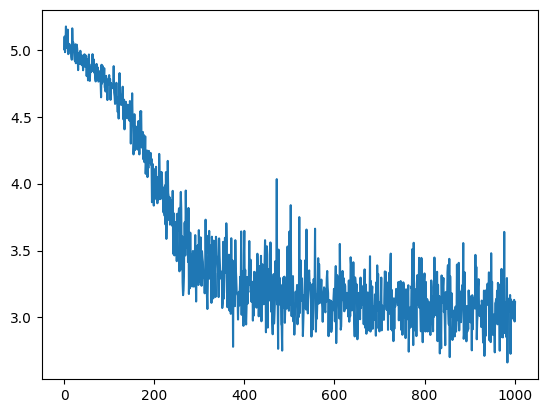

In [38]:
plt.figure()
plt.plot(Js)
plt.show()

In [ ]:
# https://kazemnejad.com/blog/transformer_architecture_positional_encoding


In [26]:
from torch.nn import functional as F

torch.manual_seed(1337)
B,T,C = 4,4,6 # batch, time, channels
x = torch.randint(10,(T,C)) * 1.0
print(x)
print(x.shape)

#Mask 
# att = torch.tril(torch.ones(T,T))
# att = att / att.sum(dim=1, keepdim=True)
# print(att)
# y = att @ x

mask = torch.tril(torch.ones(T,T))
att = torch.zeros((T,T))
att = att.masked_fill(mask[:T, :T] == 0, float("-inf"))
att = F.softmax(att, dim=-1)
print(att)

y = att @ x
print(y)




tensor([[5., 7., 2., 0., 5., 3.],
        [5., 0., 4., 0., 2., 0.],
        [7., 6., 0., 8., 1., 4.],
        [9., 5., 3., 6., 2., 0.]])
torch.Size([4, 6])
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500]])
tensor([[5.0000, 7.0000, 2.0000, 0.0000, 5.0000, 3.0000],
        [5.0000, 3.5000, 3.0000, 0.0000, 3.5000, 1.5000],
        [5.6667, 4.3333, 2.0000, 2.6667, 2.6667, 2.3333],
        [6.5000, 4.5000, 2.2500, 3.5000, 2.5000, 1.7500]])


In [32]:

def generate(f, x, max_tokens):
    # f: modelo treinado f(x)_w
    # x: contexto [x]_(B,T)
    # max_tokens: maximos tokens gerados  
    #
    f.eval()
    for i in range(max_tokens):
        x_ = x if x.size(1) <= block_size else x[:,-block_size:]
        y = f(x_) # [y]_(B=1,T,Cv)
        y = y[:,-1,...]

        # calcular a probabilidade
        p = F.softmax(y, dim=-1)

        # estimar o proximo token 
        # xt = torch.argmax(p, dim=-1, keepdim=True)
        xt = torch.multinomial(p, num_samples=1)

        x = torch.cat((x,xt), dim=1) # [x]_(B,T+1) 

        # imprimir os resultados 
        print("{}".format( dataset.from_tokens(x[0]) ))
   
    return x 

context = "Estou rodando um exemplo"
x = dataset.to_tokens(context, torch.device("cpu") )
tokens = generate(f, x, 10)

Estou rodando um exemploh
Estou rodando um exemploh“
Estou rodando um exemploh“E
Estou rodando um exemploh“Eõ
Estou rodando um exemploh“EõS
Estou rodando um exemploh“EõSx
Estou rodando um exemploh“EõSxI
Estou rodando um exemploh“EõSxI)
Estou rodando um exemploh“EõSxI)¿
Estou rodando um exemploh“EõSxI)¿ê
